In [1]:
# What version of Python do you have?
import sys
import os
import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import numpy as np
import re
import mne
import pathlib
import openpyxl
from datetime import datetime
import pytz
import random
import os
from skimage.restoration import (denoise_wavelet, estimate_sigma)
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Sequential
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix
from PIL import Image
%matplotlib inline

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Tensor Flow Version: 2.6.0
Keras Version: 2.6.0

Python 3.7.11 (default, Jul 27 2021, 09:42:29) [MSC v.1916 64 bit (AMD64)]
Pandas 1.3.3
Scikit-Learn 0.24.2
GPU is available


## CONFIG

In [4]:
os.getcwd()

windows_path = ".././windows/"

resnet152_input_shape = (224, 224)

inceptionV3_input_shape = (299, 299)

batch_size = 3

In [5]:
model = tf.keras.models.load_model("../h5_files/fneur_model.h5")

In [6]:
model.compile(
    loss="categorical_crossentropy",
    optimizer='adam',
    metrics=['accuracy']
)

## Get labels

In [26]:
labels = [item for item in os.listdir(windows_path)]

labels

['Interictal', 'Preictal_One', 'Preictal_Two', 'Seizure']

## Generate image dataframe for generator flow

In [21]:
generator = ImageDataGenerator(
rescale = 1./255, 
validation_split=0.2
)

In [27]:
genX1 = generator.flow_from_directory(windows_path, classes=labels, batch_size=batch_size, subset="validation", target_size=inceptionV3_input_shape)
genX2 = generator.flow_from_directory(windows_path, classes=labels, batch_size=batch_size, subset="validation", target_size=resnet152_input_shape)

Found 148612 images belonging to 4 classes.
Found 148612 images belonging to 4 classes.


In [23]:
def generator_two_img():
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield [X1i[0], X2i[0]], X1i[1]

## Get test windows png's

## test model

In [28]:
number_of_steps = len(genX1.filenames) // batch_size
number_of_steps

49537

In [29]:
predictions = model.predict(generator_two_img(), steps=number_of_steps)

In [30]:
real_number_preds = predictions.argmax(axis=-1)

In [33]:
y_true = genX1.classes[:-1]

In [34]:
clf_report = classification_report(y_true=y_true, y_pred=real_number_preds, target_names=labels)

C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\thoma\anaconda3\envs\AI_keras_env_GPU\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [35]:
print(clf_report)

              precision    recall  f1-score   support

  Interictal       0.94      1.00      0.97    139231
Preictal_One       0.00      0.00      0.00      5715
Preictal_Two       0.00      0.00      0.00      3132
     Seizure       0.00      0.00      0.00       533

    accuracy                           0.94    148611
   macro avg       0.23      0.25      0.24    148611
weighted avg       0.88      0.94      0.91    148611



In [36]:
labels_as_array = [x for x in labels]
type(labels_as_array[0])

str

In [37]:
confusion_matrix = confusion_matrix(y_true=y_true, y_pred=list(real_number_preds))

In [38]:
confusion_matrix

array([[139231,      0,      0,      0],
       [  5715,      0,      0,      0],
       [  3132,      0,      0,      0],
       [   533,      0,      0,      0]], dtype=int64)

In [39]:
import matplotlib

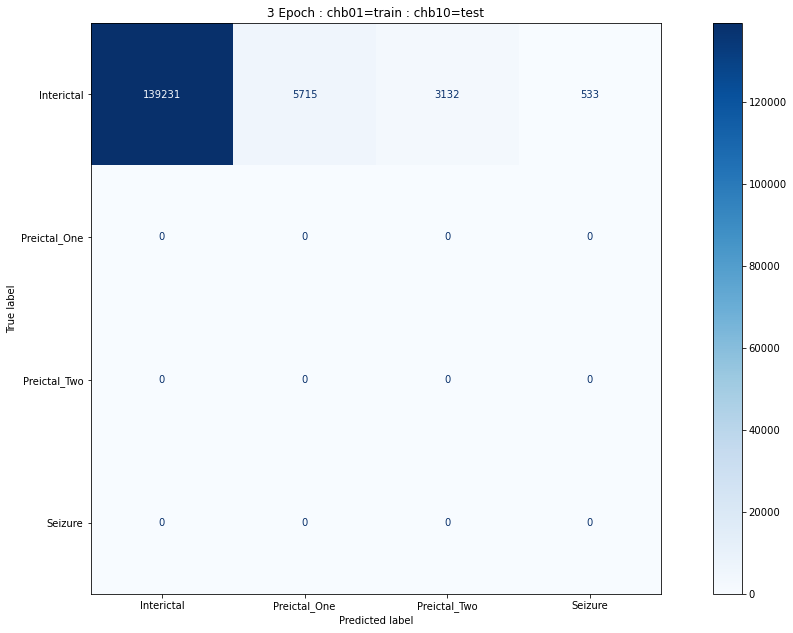

In [41]:
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels_as_array).plot(cmap='Blues')
plt.title("3 Epoch : chb01=train : chb10=test")
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(18.5, 10.5)
plt.savefig("hi.png")